In [1]:
import numpy as np
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
def sum_of_powers(G, n):
    """
    Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
    Parameters:
    - G: numpy array, the matrix G.
    - n: int, the highest power to include in the sum.
    
    Returns:
    - sum_powers: numpy array, the sum of powers of G from 1 to n.
    """
    assert n > 0, 'n must be a positive integer'  # n must be a positive integer

    sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
    current_power = np.copy(G)  # The current power of G, starting with G itself
    
    for i in range(1, n + 1):
        sum_powers += current_power  # Add the current power to the sum
        current_power = np.dot(current_power, G)  # Compute the next power of G
        
    return sum_powers

# G = np.random.rand(3, 3)  # Create a random 3x3 matrix
# print(G)  # Print the matrix G
# print('\n\n')
# n = 1  # Compute the sum of powers up to the 3rd power
# print(sum_of_powers(G, n))  # Print the result


In [110]:
def generate_matrix_with_infinity_norm_less_than_one(n):
    # Generate an n x n matrix with random values between -0.5 and 0.5
    assert n > 1, 'n must be greater than 1'

    A = (np.random.rand(n, n) - 0.5)*2
    
    # Scale each row so that the sum of the absolute values is less than 1
    for i in range(n):
        row_sum = np.sum(np.abs(A[i, :]))
        scaling_factor = np.random.uniform(low=0.0, high=1.0) / row_sum
        A[i, :] *= scaling_factor

    np.fill_diagonal(A, 0)
        
    return A


def generate_matrix_with_2_norm_less_than_one(n):

    assert n > 1, 'n must be greater than 1'

    # Generate an n x n matrix with random values
    A = (np.random.randn(n, n) - 0.5)*2
    
    # Perform SVD
    U, s, Vh = np.linalg.svd(A)
    
    # Scale singular values to ensure all are less than 1
    s_scaled = np.random.uniform(low=0.0, high=1.0, size=s.shape)
    
    # Reconstruct the matrix with scaled singular values
    A_scaled = np.dot(U, np.dot(np.diag(s_scaled), Vh))

    np.fill_diagonal(A_scaled, 0)
    
    return A_scaled


def generate_weighted_cycle(n):

    assert n > 2, 'n must be greater than 2'
    
    # Create a directed cycle graph with n nodes
    G = nx.cycle_graph(n)  # create_using=nx.DiGraph()

    # Assign random weights to the edges
    for i, j in G.edges():
        G[i][j]['weight'] = random.uniform(-1, 1)
        # G.add_edge(j, i, weight=random.uniform(-1, 1))
    
    return nx.adjacency_matrix(G).toarray()

A = generate_weighted_cycle(5)
print(A)

[[ 0.          0.35603959  0.          0.         -0.46780685]
 [ 0.35603959  0.         -0.64792144  0.          0.        ]
 [ 0.         -0.64792144  0.         -0.60061823  0.        ]
 [ 0.          0.         -0.60061823  0.          0.08462792]
 [-0.46780685  0.          0.          0.08462792  0.        ]]


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_33646/2458155103.py:51: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(G).toarray()


# Agent Utilitiy

In [111]:
def agent_utility(q, x, G, i):
    """
    Calculate the quadratic utility for agent i.
    
    Parameters:
    - q (numpy array): The linear coefficients for each agent.
    - x (numpy array): The choices or quantities selected by each agent.
    - g (numpy matrix or 2D array): The interaction coefficients between agents.
    - i (int): The index of the agent for whom to calculate the utility.
    
    Returns:
    - float: The calculated utility for agent i.
    """

    assert len(q) == len(x), 'The number of linear coefficients must match the number of agents'
    assert G.shape[0] == G.shape[1] == len(x), 'The interaction matrix must be square and have the same size as the number of agents'
    
    # Linear term for agent i
    linear_term = q[i] * x[i]
    
    # Quadratic term for agent i
    quadratic_term = -0.5 * x[i]**2
    
    # Interaction term for agent i with all other agents j
    interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
    
    # Total utility for agent i
    utility_i = linear_term + quadratic_term + interaction_term
    
    return utility_i


# Example usage
q = np.array([1, 2, 3])  # Linear coefficients for agents
# x = np.array([0.5, 1.5, 2.5])  # Choices of agents
x = np.array([random.uniform(0, 3) for i in range(3)])
print(x)
g = np.array([[0, 0.1, 0.2],  # Interaction coefficients between agents
              [0.1, 0, 0.3],
              [0.2, 0.3, 0]])
# i = 0  # Agent index for whom we're calculating the utility

for i in range(3):
    utility_i = agent_utility(q, x, g, i)
    print(f"The calculated utility for agent {i} is: {utility_i}")

[1.59262279 1.839555   1.50622713]
The calculated utility for agent 0 is: -0.44834293901622435
The calculated utility for agent 1 is: 0.8629206840911501
The calculated utility for agent 2 is: 2.0733146793708994


# Socially Optimal Solution

In [112]:
def total_utility(x, q, g):
    """
    Calculate the total utility for all agents by summing individual utilities.
    """
    assert len(q) == len(x), 'The number of linear coefficients must match the number of agents'
    assert g.shape[0] == g.shape[1] == len(x), 'The interaction matrix must be square and have the same size as the number of agents'

    return sum(agent_utility(q, x, g, i) for i in range(len(q)))


def find_social_optimum(q, g, bounds):
    """
    Find the socially optimal solution that maximizes the total utility.
    """
    assert len(q) == g.shape[0] == g.shape[1], 'The number of linear coefficients must match the number of agents, and the interaction matrix must be square'
    assert len(bounds) == len(q), 'The number of bounds must match the number of agents'
    
    num_agents = len(q)
    x0 = np.ones(num_agents)  # Initial guess for the optimization
    
    # Minimize the negative of the total utility to find the maximum total utility
    objective = lambda x: -total_utility(x, q, g)
    opt_result = minimize(objective, x0, bounds=bounds, method='SLSQP')

    return opt_result

# Individual Maximization

In [113]:
def optimize_agent_i(q, g, x, i, bounds_i):
    """
    Optimize the effort of agent i to maximize their utility.
    
    Parameters:
    - q: Cost vector.
    - g: Interaction matrix.
    - x: Vector of current efforts by all agents.
    - i: The index of the agent to optimize for.
    - bounds_i: Bounds for the optimization of agent i's effort.
    
    Returns:
    - The optimized effort for agent i.
    """
    assert len(q) == len(x), 'The number of linear coefficients must match the number of agents'
    assert g.shape[0] == g.shape[1] == len(x), 'The interaction matrix must be square and have the same size as the number of agents'

    # Define the objective function to be minimized (negative utility for maximization)
    def objective(effort):
        # Update agent i's effort in the vector
        x_new = np.array(x)
        x_new[i] = effort
        # Return negative utility to perform maximization
        return -agent_utility(q, x_new, g, i)
    
    # Initial guess for the effort of agent i
    x0 = [x[i]]
    
    # Perform the optimization
    result = minimize(objective, x0, bounds=[bounds_i], method='SLSQP')
    
    if result.success and result.x[0] > 0:
        # If optimization is successful, return the optimized effort
        return result.x[0]
    elif result.success and result.x[0] <= 0:
        # If optimization is successful and yields non-positive effort, return zero
        return 0
    else:
        # If optimization fails ?? idk!
        # print("Optimization failed:", result.message)
        return 0  # or return x[i] to keep the original effort



def maximize_individual_utilities_iteratively(q, g, initial_x, bounds, tol=1e-4, max_iter=100):
    """
    Iteratively maximize each agent's utility until convergence.
    """
    x = np.copy(initial_x)
    for iteration in range(max_iter):
        x_new = np.copy(x)
        for i in range(len(q)):
            x_new[i] = optimize_agent_i(q, g, x, i, bounds[i])

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            # print(f"Convergence achieved after {iteration + 1} iterations.")
            break
        x = x_new
    # else:
        # print("Max iterations reached without convergence.")

    return x

# Function for creating different types of networks

In [129]:
n = 10
# q = np.random.rand(n)  # Random linear coefficients for agents
q = np.ones(n)
max_hops = 10
# x_init = soc_opt_result.x
x_init = np.ones(n)

flag = True
while flag:
    # g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
    # g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
    g = generate_weighted_cycle(n)
    norm_inf_g = np.linalg.norm(g, ord=np.inf)
    norm_2_g = np.linalg.norm(g, ord=2)
    if (norm_2_g < 1 or norm_inf_g < 1):
        flag = False

# print the norm of g
print(np.linalg.norm(g, ord=np.inf))
print(np.linalg.norm(g, ord=2))

bounds = [(0, None)] * n  # Assume non-negative choices

opt_result = find_social_optimum(q, g, bounds)
print(f"\nSocially optimal solution: {opt_result.x}")
print(f"Maximum total utility: {-opt_result.fun}\n")

opt_result_2 = find_social_optimum(q, sum_of_powers(g, 2), bounds)
print(f"\nSocially optimal solution (2 hops): {opt_result_2.x}")
print(f"Maximum total utility (2 hops): {-opt_result_2.fun}\n")


utility_list = []
x_nash_list = []
util_soc_op_list = []

for hops in range(1, max_hops + 1):
    x_nash = 0
    utility = 0
    soc_opt_result = 0
    
    # compute nash equilibrium
    x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(g, hops), x_init, bounds)
    x_nash_list.append(x_nash)

    # compute total utility
    utility = total_utility(x_nash, q, sum_of_powers(g, hops))
    utility_list.append(utility)

    # compute social optimum
    soc_opt_result = find_social_optimum(q, sum_of_powers(g, hops), bounds)
    util_soc_op_list.append(-soc_opt_result.fun)


print(f"Efforts at hop {max_hops}: {x_nash_list[-1]}")
print(f"Total utility at hop {max_hops}: {total_utility(x_nash_list[-1], q, sum_of_powers(g, max_hops))}\n")


for k in range(max_hops):
    u = util_soc_op_list[-1] # sum util (inf) of x_SO_inf
    u_k = total_utility(x_nash_list[k], q, sum_of_powers(g, max_hops)) # sum util (inf) of x_k
    print(f"u - u{k+1}: {u - u_k}")

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_33646/2458155103.py:51: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(G).toarray()


1.18592256687211
0.9569845666014544

Socially optimal solution: [     0.              0.          52292.41217021   5357.98169014
      0.              0.         162824.09716335 209484.96681191
  69535.85721147  71526.52533885]
Maximum total utility: 22914661528.642834


Socially optimal solution (2 hops): [2.00810762e-01 2.06111112e-01 1.55147173e+00 1.44371881e+00
 1.49048955e-17 5.60537426e-01 1.03433600e+00 1.16624315e+00
 1.75980436e+00 1.76930499e+00]
Maximum total utility (2 hops): 4.846090864726742

Efforts at hop 10: [0.1130346  0.11021008 1.0983636  0.90825326 0.42006889 0.39569586
 0.16122304 0.27657145 1.1435058  1.13207882]
Total utility at hop 10: 3.671140421111862

u - u1: 61.10907232226664
u - u2: 1.826652543236531
u - u3: 1.1756805104151695
u - u4: 1.581234555476576
u - u5: 1.3785492176390868
u - u6: 1.6011339239853846
u - u7: 1.5121419062044446
u - u8: 1.6427501895060272
u - u9: 1.593683200120287
u - u10: 1.6790720598902125


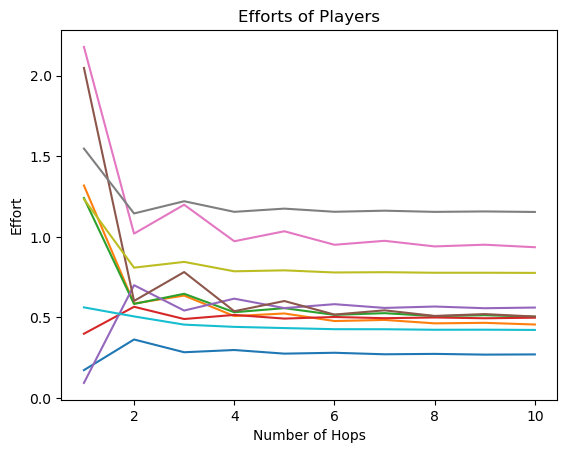

Total utility at hop 1: 8.328305704066832


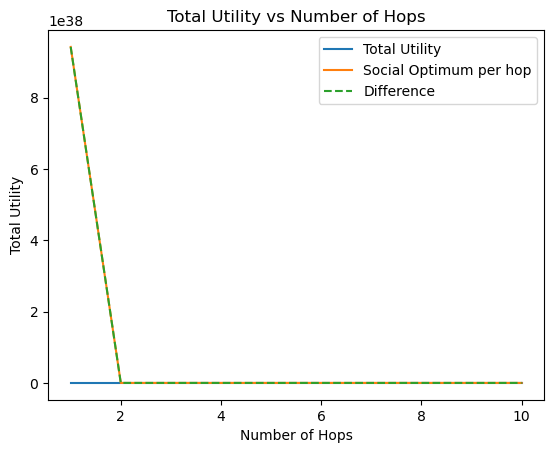

In [124]:
plt.figure()
for i in range(n):
    plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list], label=f'Player {i}')
    # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Effort")
plt.title(f"Efforts of Players")
plt.show()

# print the total utility at first hop
print(f"Total utility at hop 1: {utility_list[0]}")
plt.plot(range(1, max_hops + 1), utility_list, label='Total Utility')
plt.plot(range(1, max_hops + 1), util_soc_op_list, label='Social Optimum per hop')
# plot the difference between the social optimum pe hop and the total utility per hop
diff = [-utility_list[i] + util_soc_op_list[i] for i in range(max_hops)]
plt.plot(range(1, max_hops + 1), diff, label='Difference', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Total Utility")
plt.title("Total Utility vs Number of Hops")
plt.legend(loc='upper right')
plt.show()

# print the final utility difference
# print(f"Utility difference between hop {max_hops} and social optimum: {utility_list[-1] + soc_opt_result.fun}\n")

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_33646/2458155103.py:51: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(G).toarray()
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_33646/3225835675.py:22: RuntimeWarning: overflow encountered in double_scalars
  quadratic_term = -0.5 * x[i]**2
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_33646/3225835675.py:25: RuntimeWarning: overflow encountered in double_scalars
  interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_33646/3225835675.py:28: RuntimeWarning: invalid value encountered in double_scalars
  utility_i = linear_term + quadratic_term + 

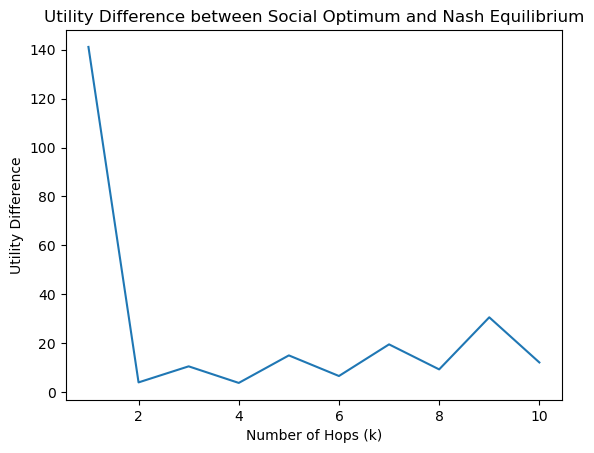

In [117]:
max_iter = 100
n = 10
q = np.ones(n)
max_hops = 10
x_init = np.ones(n)
bounds = [(0, None)] * n

def find_matrix():
    flag = True
    while flag:
        # g = generate_matrix_with_infinity_norm_less_than_one(n)  # Random interaction coefficients between agents
        # g = generate_matrix_with_2_norm_less_than_one(n)  # Random interaction coefficients between agents
        g = generate_weighted_cycle(n)
        norm_inf_g = np.linalg.norm(g, ord=np.inf)
        norm_2_g = np.linalg.norm(g, ord=2)
        if (norm_2_g < 1 or norm_inf_g < 1):
            flag = False
    return g


# Define the function to compute the difference in utility
def compute_utility_difference(k, max_hops, x_nash_list, util_soc_op_list):    
    # Compute the difference in utility
    utility_social_optimum = util_soc_op_list[-1]
    x_nash = x_nash_list[k]
    utility_nash = total_utility(x_nash, q, sum_of_powers(g, max_hops))

    utility_difference = utility_social_optimum - utility_nash
    
    return utility_difference

# Initialize the list to store the utility differences
utility_differences_list = []
for iter in range(max_iter):
    
    g = find_matrix()
    opt_result = find_social_optimum(q, g, bounds)
    if opt_result.fun > 1000:
        continue

    utility_list = []
    x_nash_list = []
    util_soc_op_list = []

    for hops in range(1, max_hops + 1):
        x_nash = 0
        utility = 0
        soc_opt_result = 0
        
        # compute nash equilibrium
        x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(g, hops), x_init, bounds)
        x_nash_list.append(x_nash)

        # compute total utility
        utility = total_utility(x_nash, q, sum_of_powers(g, hops))
        utility_list.append(utility)

        # compute social optimum
        soc_opt_result = find_social_optimum(q, sum_of_powers(g, hops), bounds)
        util_soc_op_list.append(-soc_opt_result.fun)    

    # Compute the utility difference for different values of k
    utility_differences = [compute_utility_difference(k, max_hops, x_nash_list, util_soc_op_list) for k in range(max_hops)]
    utility_differences_list.append(utility_differences)

# Compute the average utility differences
utility_differences_mean = np.mean(utility_differences_list, axis=0)

# Plot the utility difference vs k
plt.plot(range(1, max_hops + 1), utility_differences_mean, label='Average Utility Difference')
plt.xlabel('Number of Hops (k)')
plt.ylabel('Utility Difference')
plt.title('Utility Difference between Social Optimum and Nash Equilibrium')
plt.show()


In [118]:
print(len(utility_differences_list))

100


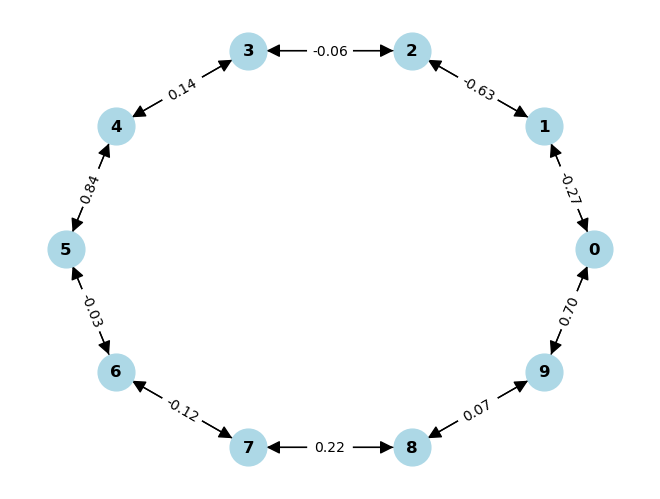

In [97]:
G = nx.DiGraph(g)
# Position nodes using the spring layout
pos = nx.circular_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_weight='bold', arrowsize=20)

# Draw edge labels with two decimal places
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis('off')  # Hide axes
plt.show()

In [32]:
G_ex1 = g
print(G_ex1)

[[ 0.00000000e+00  4.73812718e-02 -4.37638599e-01  2.16638512e-01
  -2.40535583e-01 -1.01172284e-01 -4.98993265e-02 -1.40567177e-02
  -7.32730244e-02  1.52518126e-04]
 [-3.03493817e-01  0.00000000e+00  3.37986680e-02  3.01385361e-01
   2.87338423e-02 -1.24120944e-01  2.69080562e-01  3.95184606e-01
  -7.58023050e-02  5.27111922e-02]
 [ 2.56954913e-02 -2.44558381e-01  0.00000000e+00  9.07337960e-02
  -1.27027636e-01  1.04485494e-01 -1.73046677e-01  5.07352664e-02
  -9.89486172e-03 -9.29314815e-02]
 [-3.34520465e-02 -4.07570745e-01 -1.24635939e-01  0.00000000e+00
  -4.68336166e-02  1.77014552e-01  9.27844060e-02 -3.09081687e-01
   1.54539791e-01 -2.00238289e-03]
 [ 4.44821648e-02  1.13222923e-01 -1.35064669e-01 -1.74012784e-02
   0.00000000e+00 -3.31561111e-02  7.36695150e-02 -2.49101743e-01
   6.50681740e-02 -3.55561260e-01]
 [-1.34524542e-01 -5.75859978e-02 -2.96070846e-01  1.59981241e-01
   8.70766365e-02  0.00000000e+00 -1.68659812e-02 -1.05619137e-01
  -2.14431753e-01  8.56154922e-02